In [1]:
import numpy as np
print("np: ", np.__version__)
import matplotlib
print("mpl: ", matplotlib.__version__)
import numpy as np
import scipy.stats as sst
import scipy as sp
print("sp: ", sp.__version__)
import matplotlib.pylab as plt
import scipy.spatial.distance as ssp
import pandas as pd

from IPython.display import Image
from IPython.display import display
from IPython.display import SVG
from ipywidgets import interact,Checkbox,Text,VBox

import helpers.theo_variogram_fct as vario

import datetime
import helpers.kriging as kri
import helpers.variogram as variokri

np:  1.16.5
mpl:  3.1.1
sp:  1.3.1


In [2]:
#import data iron concentration
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()
#print(xyz[:3])

#reduce coordenate numbers
xyz[:,0]= xyz[:,0] - min(xyz[:,0])
xyz[:,1]= xyz[:,1] - min(xyz[:,1])
#print(xyz[:3])

#to define grid (to match sample points with each cell of grid)
delta_x = 1000        #meters (it depends on the data set dimensions)
delta_y = delta_x     #meters. To keep square cells

(539, 2)


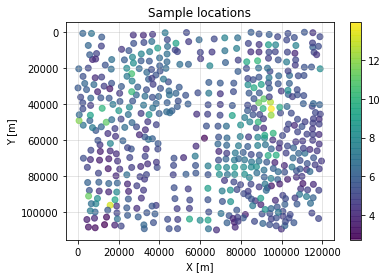

In [3]:
#Scatter plot of samples
xy = xyz[:,0:2] #the coordenate x is the second column and y the first one. 
print(xy.shape)

y = xyz[:,0] #The first coordenate is y rather than x as usual.
x = xyz[:,1]
z = xyz[:,2]


plt.scatter(x, y, c=z, alpha=0.7)
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.title('Sample locations')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True, alpha=0.4)
plt.savefig('1_sample_original_points_map.png', dpi=300) #save a nice .png of this map.

539
328


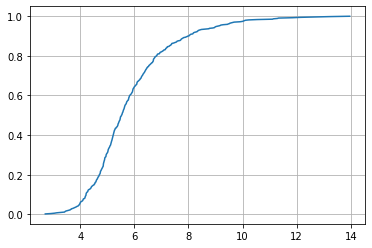

In [4]:
#Calculates the cummulative distribution function of data z
def function_cdf(z):
    s = np.sort(z)
    z_values = np.unique(s)
    pdf = []
    for i in range(len(z_values)-1):
        pdf.append(len(z[(s >= z_values[i]) & (s < z_values[i+1])])/len(s))
    cdf = np.cumsum(pdf)
    cdf = np.append(cdf,1)
    return z_values, cdf

values_cdf, cdf = function_cdf(z)

print(z.size)
print(values_cdf.size)

#Original data
plt.figure()
plt.grid()
plt.plot(values_cdf, cdf)
plt.savefig('2_CDF_Original_data.png', dpi=300) #save a nice .png of this map.

min = -2.9058541750122475 max = 2.861769176055261


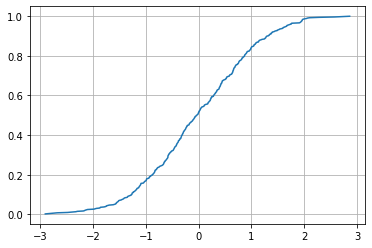

In [5]:
#Data to be transformed
np.random.seed(1000)
normal_data = np.array(np.random.normal(0,1,len(z)))
values_cdf_normal, cdf_normal = function_cdf(normal_data)

plt.figure()
plt.plot(values_cdf_normal, cdf_normal)
plt.grid()
plt.savefig('3_CDF_Normal_data.png', dpi=300) #save a nice .png of this map.
print("min =", min(normal_data), "max =", max(normal_data))


In [6]:
#Normalization of data z
#NOTE: DUE TO ASSIGNATION OF NEW VALUES TO z variable at the end of this cell-code, from the second execution this cell-code doesnt work properly.
#      To fix it run again the cell above to reset values of "z".
z_norm = []
for value in z:
    pos = np.where(values_cdf==value)[0][0]                        #finds cummulative probability of the value
    inter = sp.interpolate.interp1d(cdf_normal,values_cdf_normal)  #To make it continous
    z_norm.append(inter(cdf[pos]))                                 #looks for the normed value with the same cumm probability

z_norm = np.array(z_norm)

print('max z normalized value =', max(z))
print('min z normalized value =', min(z))

max z normalized value = 13.96
min z normalized value = 2.71


total number of distances = 144991
max distance = 155400.2 [m]
min distance = 1419.2 [m]
dimensions of D =  (539, 539)


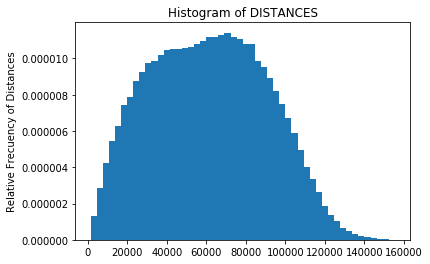

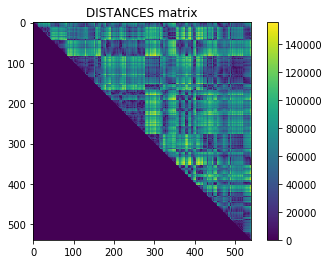

In [7]:
H = ssp.pdist(xy, metric='euclidean')
D = ssp.squareform(H)
upper = np.triu(D)
upper_vector = np.matrix.flatten(upper)
upper_vector = upper_vector[upper_vector>0]
print("total number of distances =", upper_vector.shape[0])
plt.hist(upper_vector, bins = 50, density='true') # bins = np.arange(0, np.round(max(H),0)+1 , delta_x)
plt.title("Histogram of DISTANCES")
plt.ylabel('Relative Frecuency of Distances')
print("max distance =",np.round(max(H),1),"[m]")
print("min distance =",np.round(min(H),1),"[m]")
print("dimensions of D = ",upper.shape)
plt.savefig('3_Histogram_Distances.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.imshow(upper)
plt.title("DISTANCES matrix")
plt.colorbar()
plt.savefig('4_Distances_matrix.png', dpi=300) #save a nice .png of this map.

### Correlogram

In [8]:
n = np.linspace(1000,40000,40)
bins = np.array(n)
print(bins)
print(type(bins))

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000. 20000.
 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000. 30000.
 31000. 32000. 33000. 34000. 35000. 36000. 37000. 38000. 39000. 40000.]
<class 'numpy.ndarray'>


In [9]:
ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances

ix = np.array(np.where(np.logical_and(D>bins[0], D<=bins[1])))
print(ix.shape)

(2, 26)


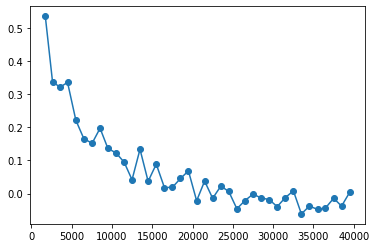

In [10]:
F = z_norm

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1]))
    d_mean.append(D[ix].mean())
    F_0 = F[ix[0]]
    F_1 = F[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0]
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)

#plot
plt.plot(d_mean,
         rs,
        'o-')
plt.savefig('5_Correlogram.png', dpi=300) #save a nice .png of this map.

### Empiric Variogram

In [11]:
Z1, Z2 = np.meshgrid(F, F)
sem_var = (Z1-Z2)**2.
sem_vars = []
co_vars = []
sem_vars_v2 = []
n_pts = []

for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    #print cur_i_bin, cur_bin
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
#     print len(ix)
#     print "  ", ix[0].shape, ix[0].min(), ix[0].max()
#     print "  ", ix[1].shape, ix[1].min(), ix[1].max()
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    #print sem_var_cur
    sem_vars.append(sem_var_cur)
    
    #print"      ",  ix[0].shape[0]
    sem_var_v2 = np.sum((F[ix[1]] - F[ix[0]])**2)/(2.0 * ix[0].shape[0])
    sem_vars_v2.append(sem_var_v2)
    
    mean = F[ix[1]].mean()
    covar = np.sum((F[ix[1]]-mean)* (F[ix[0]]-mean))/( ix[0].shape[0])
    co_vars.append(covar)

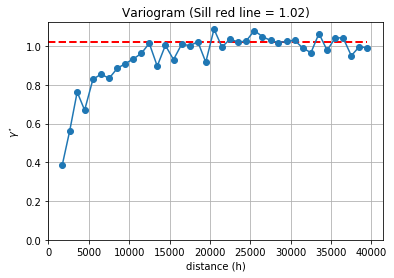

In [12]:
#Sill calculation
sill = np.var(z_norm)  #the sill is the variance of z normalized values
plt.hlines(y=sill, xmin=0, xmax=max(d_mean), colors='r', linestyles='--', lw=2) # plot sill as red dashed line.
plt.plot(d_mean, np.array(sem_vars), marker ='o')                               # plot empirical variogram
plt.grid(True)
plt.title('Variogram (Sill red line = ' + str(np.round(sill,2)) + ')')
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)
plt.savefig('6_Variogram.png', dpi=300) #save a nice .png of this map.
plt.show()

### Initialize grid and assignation of sample values to proper cells

In [13]:
nx = 2 + int(max(x)/delta_x)       #number of required cells in x-axis
ny = 2 + int(max(y)/delta_y)       #number of required cells in y-axis
print("x max =", max(x), ", y max =", max(y))
print("This map require", nx, "cells in x-axis and", ny,"in y-xis")

x max = 119592.0 , y max = 109987.0
This map require 121 cells in x-axis and 111 in y-xis


In [14]:
#Initialize grid
X,Y = np.mgrid[0:int(delta_y+max(y)):delta_y, 0:int(delta_x+max(x)):delta_x] #is assigned y-related to row and x-related to columns

#Initialize the entire matrix with "None" values
Z = np.zeros([X.shape[0],X.shape[1]])  #it can be with X.shape or Y.shape coz both have same dimensions.
Z[:,:]=None
print('Z dimensions =',Z.shape)

##plot
# plt.imshow(Z, aspect='auto')
# plt.colorbar()
# plt.grid(True)

Z dimensions = (111, 121)


max_z_normal value = 2.861769176055261
min_z_normal value = -2.9058541750122475


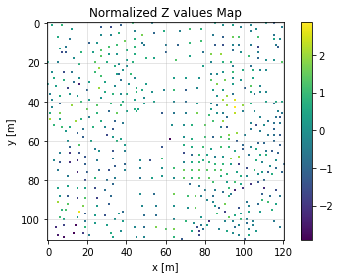

In [15]:
#Assign value of normalized samples (z) to corresponding cells in initialized matrix (Z)

i=0
observations_index = []
while i< x.shape[0]:
    x_i = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    y_i = int(np.round(y[i]/delta_y,0))
    Z[y_i,x_i] = z_norm[i]
    observations_index.append([y_i,x_i])
    i = i+1

print('max_z_normal value =', max(z_norm))
print('min_z_normal value =', min(z_norm))

plt.imshow(Z, aspect='equal')
plt.grid(True, alpha=0.4)
plt.colorbar()
plt.title('Normalized Z values Map')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('7_samples_in_grid_map.png', dpi=300) #save a nice .png of this map.

In [16]:
i=0
observations_index = []
while i< x.shape[0]:
    column = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    raw = int(np.round(y[i]/delta_y,0))
 
    Z[raw][column] = z_norm[i]
    observations_index.append([raw,column])
    i = i+1

# Theoretical Variogram Models

In [17]:
# Define Dictionaries of Theoretical Variogram Models

# Dictionary for individual variogram models. Reference the theo_variogram_fct python file
models = {'Exponential': vario.ExponentialVariogram,
          'Spherical': vario.SphericalVariogram,
          'Gaussian': vario.GaussianVariogram,
          'Linear': vario.LinearVariogram}

# Dictionary for individual short-form variogram models to be used for composited variogram models
mods = {'Exp': vario.ExponentialVariogram,
        'Sph': vario.SphericalVariogram,
        'Gau': vario.GaussianVariogram,
        'Lin': vario.LinearVariogram}

In [18]:
# plotting for function for individual models
def plot_varmodel(Sill, Range, Model):
    v_model = Model(Sill, Range, h)
    plt.plot(h,v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\\gamma$')
    plt.xlim(0.,max(h))
    plt.ylim(0.,)
    plt.grid(True)
    plt.show()

# plotting function for multiple variogram models 
def plot_n_varmodel(Sill, Range):
    for cur_i, var_model in enumerate(var_models):
        v_model = var_model(Sill, Range, h)
        plt.plot(h,v_model, label=models_to_plot[cur_i]) # Model Variogram
        plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
        plt.xlabel('distance')
        plt.ylabel('$\\gamma$')
        plt.xlim(0.,max(h))
        plt.ylim(0.,)
        plt.grid(True)
    plt.legend(loc='best')
    plt.show()

# plotting function for nested models   
def plot_nes_varmodel(h,mod):
    v_model = nest_vario.Variogram(h, model = mod.value)
    plt.plot(h, v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\gamma^{\star}$')
    plt.ylim(0.,sum(var_sill)*1.5)
    plt.xlim(0.,max(h))
    plt.grid(True)
    plt.show()

In [19]:
max(d_mean)

39497.25101963115

In [20]:
# Determine first guess of sill and range from empirical variogram
var_sill = np.round(np.max(np.array(sem_vars)),decimals = 2)
h = np.linspace(0, max(d_mean),  int(max(d_mean)/10.))
var_range = np.round(np.max(np.array(d_mean)),decimals = 2)
print(np.max(np.array(sem_vars)))
print(var_sill)

1.086964200299213
1.09


## Interactive Plot #1

With this interactive display, using slider bars, you can adjust the SILL and the RANGE for a Variogram Model selected from a dropdown list. The graph axes will update automatically.

In [21]:
# Trigger Interactive Plot
# recommended parameters : (sill = 1, range = 4350)
import importlib
importlib.reload(vario)
interact(plot_varmodel,
         Sill =(var_sill/100,var_sill*1.5,0.01),
         Range = (0,max(h), max(h)/100),
         Model = models)

interactive(children=(FloatSlider(value=0.8209000000000001, description='Sill', max=1.6350000000000002, min=0.…

<function __main__.plot_varmodel(Sill, Range, Model)>

# Interpolate (Kriging)

In [22]:
# number conditioning points
n_cond = 10

In [23]:
controls = (np.dstack([x,y]))[0] #return first array of all (x,y) location of sample points.
print(controls.shape)
# print(controls)

(539, 2)


In [24]:
if len(controls.shape)<3: #to avoid in multiple runs add more dimensions
    controls = controls[:, np.newaxis, :]
print(len(controls.shape))
print(controls.shape)

3
(539, 1, 2)


In [25]:
x_min = np.min(x)
x_max = np.max(x)
y_min = np.min(y)
y_max = np.max(y)

print(f'x:  min={x_min}, max={x_max}')
print(f'y:  min={y_min}, max={y_max}')

x:  min=0.0, max=119592.0
y:  min=0.0, max=109987.0


In [26]:
i_index, j_index = np.meshgrid(range(Z.shape[0]), range(Z.shape[1]), indexing='ij')#meshgrid with index 
index = np.column_stack((np.concatenate(i_index), np.concatenate(j_index)))#rows and columns append in order to have a vector of all possible indexes (i,j) in the matrix 

index_to_simulate = [i for i in index.tolist() if i not in observations_index]#Delete from the matrix the 'observed data'

xe = Y[0,:][np.array(index_to_simulate)[:,1]]#Columns are coordinate x
ye = X[:,0][np.array(index_to_simulate)[:,0]]#Rows are coordinate y

targets = np.column_stack((xe, ye))

print("Number of cell in meshgrid =",targets.shape[0])

Number of cell in meshgrid = 12892


In [27]:
# measurement values
controlvalues = z_norm


In [28]:
var_sample = np.var(controlvalues)
print(var_sample)

1.018511018533664


In [29]:
# Variogram Parameters
expo = variokri.ExponentialVariogram({'sill': 1.03,
                                   'range': 4344.70,
                                   'variance': var_sample})


sph = variokri.SphericalVariogram({'sill': 1.03,
                             'range': 9084.37})


fitted_variogram = variokri.CompositeVariogram()
fitted_variogram.addVariogram(expo)

In [30]:
ok_results = []
interpolation_kri = np.copy(Z)
std_kri = np.zeros((Z.shape[0],Z.shape[1]))

ok_result = kri.krige_ok(controls
                       , targets
                       , controlvalues
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
print ('ID \t x \t y \t est(z)')
for i, result in enumerate(ok_result):
    print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(i, targets[i][0], targets[i][1], result[1]))
    # the weights are stored in results[0] but not saved here
    interpolation_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[1]
    std_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[2]
    ok_results.append([result[1], result[2]])

ID 	 x 	 y 	 est(z)
 0	0.00	0.00	0.33
 1	1000.00	0.00	0.36
 2	2000.00	0.00	0.44
 3	3000.00	0.00	0.51
 4	4000.00	0.00	0.59
 5	5000.00	0.00	0.62
 6	6000.00	0.00	0.72
 7	7000.00	0.00	0.72
 8	8000.00	0.00	0.58
 9	9000.00	0.00	0.44
10	10000.00	0.00	0.33
11	11000.00	0.00	0.23
12	12000.00	0.00	0.09
13	13000.00	0.00	-0.01
14	14000.00	0.00	-0.01
15	15000.00	0.00	-0.09
16	16000.00	0.00	-0.16
17	17000.00	0.00	-0.22
18	18000.00	0.00	-0.37
19	19000.00	0.00	-0.32
20	20000.00	0.00	-0.39
21	21000.00	0.00	-0.44
22	22000.00	0.00	-0.63
23	23000.00	0.00	-0.72
24	24000.00	0.00	-0.70
25	25000.00	0.00	-0.81
26	26000.00	0.00	-0.94
27	27000.00	0.00	-1.05
28	28000.00	0.00	-1.11
29	29000.00	0.00	-1.14
30	30000.00	0.00	-1.13
31	31000.00	0.00	-1.17
32	32000.00	0.00	-1.19
33	33000.00	0.00	-1.18
34	34000.00	0.00	-1.09
35	35000.00	0.00	-1.02
36	36000.00	0.00	-0.97
37	37000.00	0.00	-0.80
38	38000.00	0.00	-0.51
39	39000.00	0.00	-0.13
40	40000.00	0.00	0.16
41	41000.00	0.00	0.40
42	42000.00	0.00	0.71
43	44000.00	0.00	0.7

329	101000.00	2000.00	-0.35
330	102000.00	2000.00	-0.35
331	103000.00	2000.00	-0.33
332	104000.00	2000.00	-0.28
333	105000.00	2000.00	-0.24
334	106000.00	2000.00	-0.20
335	107000.00	2000.00	-0.15
336	108000.00	2000.00	-0.07
337	109000.00	2000.00	-0.03
338	110000.00	2000.00	-0.01
339	111000.00	2000.00	-0.08
340	112000.00	2000.00	-0.23
341	113000.00	2000.00	-0.43
342	114000.00	2000.00	-0.64
343	115000.00	2000.00	-0.79
344	116000.00	2000.00	-0.81
345	117000.00	2000.00	-0.72
346	118000.00	2000.00	-0.59
347	120000.00	2000.00	-0.43
348	0.00	3000.00	0.35
349	1000.00	3000.00	0.40
350	2000.00	3000.00	0.43
351	3000.00	3000.00	0.50
352	4000.00	3000.00	0.55
353	5000.00	3000.00	0.60
354	6000.00	3000.00	0.61
355	7000.00	3000.00	0.57
356	8000.00	3000.00	0.49
357	9000.00	3000.00	0.37
358	10000.00	3000.00	0.28
359	11000.00	3000.00	0.22
360	13000.00	3000.00	0.07
361	14000.00	3000.00	-0.01
362	15000.00	3000.00	-0.12
363	16000.00	3000.00	-0.18
364	17000.00	3000.00	-0.23
365	18000.00	3000.00	-0.30
366	1900

636	56000.00	5000.00	-0.48
637	57000.00	5000.00	-0.21
638	58000.00	5000.00	0.07
639	59000.00	5000.00	0.32
640	60000.00	5000.00	0.38
641	61000.00	5000.00	0.27
642	62000.00	5000.00	0.12
643	63000.00	5000.00	-0.01
644	64000.00	5000.00	-0.12
645	65000.00	5000.00	-0.22
646	66000.00	5000.00	-0.26
647	67000.00	5000.00	-0.22
648	68000.00	5000.00	-0.05
649	69000.00	5000.00	0.19
650	70000.00	5000.00	0.43
651	71000.00	5000.00	0.66
652	72000.00	5000.00	0.83
653	73000.00	5000.00	0.91
654	74000.00	5000.00	0.92
655	75000.00	5000.00	0.89
656	76000.00	5000.00	0.87
657	77000.00	5000.00	0.84
658	78000.00	5000.00	0.76
659	79000.00	5000.00	0.64
660	80000.00	5000.00	0.46
661	81000.00	5000.00	0.26
662	82000.00	5000.00	0.03
663	83000.00	5000.00	-0.15
664	84000.00	5000.00	-0.32
665	85000.00	5000.00	-0.43
666	86000.00	5000.00	-0.51
667	87000.00	5000.00	-0.56
668	88000.00	5000.00	-0.58
669	89000.00	5000.00	-0.49
670	90000.00	5000.00	-0.25
671	91000.00	5000.00	0.08
672	92000.00	5000.00	0.45
673	93000.00	5000.00	0

949	17000.00	8000.00	-0.42
950	18000.00	8000.00	-0.50
951	19000.00	8000.00	-0.61
952	20000.00	8000.00	-0.73
953	21000.00	8000.00	-0.79
954	22000.00	8000.00	-0.76
955	23000.00	8000.00	-0.58
956	24000.00	8000.00	-0.42
957	25000.00	8000.00	-0.24
958	26000.00	8000.00	-0.08
959	27000.00	8000.00	0.05
960	28000.00	8000.00	0.14
961	29000.00	8000.00	0.18
962	30000.00	8000.00	0.21
963	31000.00	8000.00	0.26
964	32000.00	8000.00	0.34
965	33000.00	8000.00	0.46
966	34000.00	8000.00	0.62
967	35000.00	8000.00	0.80
968	36000.00	8000.00	0.98
969	37000.00	8000.00	1.12
970	38000.00	8000.00	1.26
971	39000.00	8000.00	1.35
972	40000.00	8000.00	1.23
973	41000.00	8000.00	1.08
974	42000.00	8000.00	0.91
975	43000.00	8000.00	0.81
976	45000.00	8000.00	0.62
977	46000.00	8000.00	0.56
978	47000.00	8000.00	0.53
979	48000.00	8000.00	0.51
980	49000.00	8000.00	0.41
981	50000.00	8000.00	0.24
982	51000.00	8000.00	0.00
983	52000.00	8000.00	-0.18
984	53000.00	8000.00	-0.38
985	54000.00	8000.00	-0.42
986	55000.00	8000.00	-0.4

1275	110000.00	10000.00	-0.29
1276	111000.00	10000.00	-0.25
1277	112000.00	10000.00	-0.21
1278	113000.00	10000.00	-0.13
1279	114000.00	10000.00	-0.10
1280	115000.00	10000.00	-0.10
1281	116000.00	10000.00	-0.21
1282	117000.00	10000.00	-0.36
1283	118000.00	10000.00	-0.44
1284	119000.00	10000.00	-0.43
1285	120000.00	10000.00	-0.43
1286	0.00	11000.00	0.22
1287	1000.00	11000.00	0.25
1288	2000.00	11000.00	0.28
1289	3000.00	11000.00	0.31
1290	4000.00	11000.00	0.34
1291	5000.00	11000.00	0.33
1292	6000.00	11000.00	0.22
1293	7000.00	11000.00	0.00
1294	8000.00	11000.00	-0.24
1295	9000.00	11000.00	-0.42
1296	10000.00	11000.00	-0.48
1297	11000.00	11000.00	-0.49
1298	12000.00	11000.00	-0.44
1299	13000.00	11000.00	-0.37
1300	14000.00	11000.00	-0.29
1301	15000.00	11000.00	-0.22
1302	16000.00	11000.00	-0.17
1303	17000.00	11000.00	-0.19
1304	18000.00	11000.00	-0.26
1305	19000.00	11000.00	-0.34
1306	20000.00	11000.00	-0.45
1307	21000.00	11000.00	-0.53
1308	22000.00	11000.00	-0.47
1309	23000.00	11000.00	-

1565	53000.00	13000.00	-0.10
1566	54000.00	13000.00	-0.12
1567	55000.00	13000.00	-0.21
1568	56000.00	13000.00	-0.34
1569	57000.00	13000.00	-0.44
1570	58000.00	13000.00	-0.57
1571	59000.00	13000.00	-0.71
1572	60000.00	13000.00	-0.80
1573	61000.00	13000.00	-0.78
1574	62000.00	13000.00	-0.70
1575	63000.00	13000.00	-0.62
1576	64000.00	13000.00	-0.57
1577	65000.00	13000.00	-0.50
1578	66000.00	13000.00	-0.41
1579	67000.00	13000.00	-0.26
1580	68000.00	13000.00	-0.09
1581	69000.00	13000.00	0.10
1582	70000.00	13000.00	0.26
1583	71000.00	13000.00	0.39
1584	72000.00	13000.00	0.51
1585	73000.00	13000.00	0.52
1586	74000.00	13000.00	0.49
1587	75000.00	13000.00	0.38
1588	76000.00	13000.00	0.29
1589	77000.00	13000.00	0.18
1590	78000.00	13000.00	0.09
1591	79000.00	13000.00	0.07
1592	80000.00	13000.00	0.10
1593	81000.00	13000.00	0.15
1594	82000.00	13000.00	0.17
1595	83000.00	13000.00	0.14
1596	84000.00	13000.00	0.05
1597	85000.00	13000.00	-0.03
1598	86000.00	13000.00	-0.08
1599	87000.00	13000.00	-0.08
1

1866	2000.00	16000.00	-0.10
1867	3000.00	16000.00	-0.23
1868	4000.00	16000.00	-0.40
1869	5000.00	16000.00	-0.65
1870	6000.00	16000.00	-0.98
1871	7000.00	16000.00	-1.29
1872	8000.00	16000.00	-1.28
1873	9000.00	16000.00	-1.12
1874	10000.00	16000.00	-0.88
1875	11000.00	16000.00	-0.63
1876	12000.00	16000.00	-0.39
1877	13000.00	16000.00	-0.15
1878	14000.00	16000.00	0.10
1879	15000.00	16000.00	0.36
1880	16000.00	16000.00	0.62
1881	17000.00	16000.00	0.72
1882	18000.00	16000.00	0.65
1883	19000.00	16000.00	0.59
1884	20000.00	16000.00	0.53
1885	21000.00	16000.00	0.50
1886	22000.00	16000.00	0.48
1887	23000.00	16000.00	0.54
1888	24000.00	16000.00	0.75
1889	25000.00	16000.00	0.97
1890	26000.00	16000.00	1.15
1891	27000.00	16000.00	1.23
1892	28000.00	16000.00	1.13
1893	29000.00	16000.00	0.90
1894	30000.00	16000.00	0.60
1895	32000.00	16000.00	0.30
1896	33000.00	16000.00	0.28
1897	34000.00	16000.00	0.22
1898	36000.00	16000.00	0.21
1899	37000.00	16000.00	0.30
1900	38000.00	16000.00	0.38
1901	39000.00	16

2172	77000.00	18000.00	-0.01
2173	78000.00	18000.00	-0.03
2174	79000.00	18000.00	0.02
2175	80000.00	18000.00	0.17
2176	81000.00	18000.00	0.41
2177	82000.00	18000.00	0.69
2178	83000.00	18000.00	0.90
2179	84000.00	18000.00	0.99
2180	85000.00	18000.00	1.03
2181	86000.00	18000.00	1.11
2182	87000.00	18000.00	1.20
2183	88000.00	18000.00	1.24
2184	89000.00	18000.00	1.15
2185	90000.00	18000.00	0.96
2186	91000.00	18000.00	0.77
2187	92000.00	18000.00	0.59
2188	93000.00	18000.00	0.42
2189	94000.00	18000.00	0.25
2190	95000.00	18000.00	0.11
2191	96000.00	18000.00	0.06
2192	97000.00	18000.00	0.02
2193	98000.00	18000.00	0.07
2194	99000.00	18000.00	0.16
2195	100000.00	18000.00	0.26
2196	101000.00	18000.00	0.37
2197	102000.00	18000.00	0.41
2198	103000.00	18000.00	0.29
2199	104000.00	18000.00	-0.02
2200	105000.00	18000.00	-0.36
2201	106000.00	18000.00	-0.70
2202	108000.00	18000.00	-0.71
2203	109000.00	18000.00	-0.55
2204	110000.00	18000.00	-0.39
2205	111000.00	18000.00	-0.28
2206	112000.00	18000.00	-0.2

2465	22000.00	21000.00	1.10
2466	23000.00	21000.00	1.22
2467	24000.00	21000.00	1.36
2468	25000.00	21000.00	1.47
2469	26000.00	21000.00	1.51
2470	27000.00	21000.00	1.44
2471	28000.00	21000.00	1.27
2472	29000.00	21000.00	1.04
2473	30000.00	21000.00	0.81
2474	31000.00	21000.00	0.69
2475	32000.00	21000.00	0.61
2476	33000.00	21000.00	0.52
2477	34000.00	21000.00	0.37
2478	35000.00	21000.00	0.11
2479	37000.00	21000.00	-0.16
2480	38000.00	21000.00	-0.11
2481	39000.00	21000.00	-0.06
2482	40000.00	21000.00	-0.03
2483	41000.00	21000.00	0.15
2484	42000.00	21000.00	0.39
2485	43000.00	21000.00	0.58
2486	44000.00	21000.00	0.64
2487	45000.00	21000.00	0.63
2488	46000.00	21000.00	0.61
2489	47000.00	21000.00	0.60
2490	48000.00	21000.00	0.60
2491	49000.00	21000.00	0.55
2492	50000.00	21000.00	0.54
2493	51000.00	21000.00	0.52
2494	52000.00	21000.00	0.43
2495	53000.00	21000.00	0.45
2496	54000.00	21000.00	0.41
2497	55000.00	21000.00	0.40
2498	56000.00	21000.00	0.32
2499	57000.00	21000.00	0.22
2500	58000.00	21

2757	79000.00	23000.00	0.20
2758	80000.00	23000.00	0.10
2759	81000.00	23000.00	-0.02
2760	82000.00	23000.00	-0.13
2761	83000.00	23000.00	-0.19
2762	84000.00	23000.00	-0.17
2763	85000.00	23000.00	-0.11
2764	86000.00	23000.00	-0.02
2765	87000.00	23000.00	0.07
2766	88000.00	23000.00	0.16
2767	89000.00	23000.00	0.27
2768	90000.00	23000.00	0.35
2769	91000.00	23000.00	0.39
2770	92000.00	23000.00	0.38
2771	93000.00	23000.00	0.29
2772	94000.00	23000.00	0.15
2773	95000.00	23000.00	0.14
2774	96000.00	23000.00	0.20
2775	97000.00	23000.00	0.27
2776	98000.00	23000.00	0.35
2777	99000.00	23000.00	0.37
2778	100000.00	23000.00	0.25
2779	101000.00	23000.00	0.17
2780	102000.00	23000.00	0.07
2781	103000.00	23000.00	0.04
2782	104000.00	23000.00	0.07
2783	105000.00	23000.00	-0.00
2784	106000.00	23000.00	-0.12
2785	107000.00	23000.00	-0.22
2786	108000.00	23000.00	-0.29
2787	109000.00	23000.00	-0.28
2788	110000.00	23000.00	-0.24
2789	111000.00	23000.00	-0.17
2790	112000.00	23000.00	-0.08
2791	113000.00	23000.

3048	18000.00	26000.00	0.30
3049	19000.00	26000.00	0.39
3050	20000.00	26000.00	0.51
3051	21000.00	26000.00	0.62
3052	22000.00	26000.00	0.72
3053	23000.00	26000.00	0.82
3054	24000.00	26000.00	0.94
3055	25000.00	26000.00	1.09
3056	26000.00	26000.00	1.20
3057	27000.00	26000.00	1.21
3058	28000.00	26000.00	1.13
3059	29000.00	26000.00	1.00
3060	30000.00	26000.00	0.87
3061	31000.00	26000.00	0.75
3062	32000.00	26000.00	0.63
3063	33000.00	26000.00	0.49
3064	34000.00	26000.00	0.43
3065	37000.00	26000.00	-0.60
3066	38000.00	26000.00	-0.34
3067	39000.00	26000.00	-0.05
3068	40000.00	26000.00	0.26
3069	41000.00	26000.00	0.60
3070	43000.00	26000.00	0.58
3071	44000.00	26000.00	0.30
3072	45000.00	26000.00	0.16
3073	46000.00	26000.00	0.16
3074	47000.00	26000.00	0.23
3075	48000.00	26000.00	0.28
3076	49000.00	26000.00	0.32
3077	50000.00	26000.00	0.35
3078	51000.00	26000.00	0.38
3079	52000.00	26000.00	0.31
3080	53000.00	26000.00	0.30
3081	54000.00	26000.00	0.30
3082	55000.00	26000.00	0.36
3083	56000.00	260

3346	86000.00	28000.00	0.67
3347	87000.00	28000.00	0.77
3348	88000.00	28000.00	0.91
3349	89000.00	28000.00	1.08
3350	90000.00	28000.00	1.16
3351	91000.00	28000.00	0.97
3352	92000.00	28000.00	0.64
3353	93000.00	28000.00	0.27
3354	95000.00	28000.00	0.18
3355	96000.00	28000.00	0.20
3356	97000.00	28000.00	0.19
3357	98000.00	28000.00	0.20
3358	99000.00	28000.00	0.21
3359	100000.00	28000.00	0.25
3360	101000.00	28000.00	0.32
3361	102000.00	28000.00	0.40
3362	103000.00	28000.00	0.43
3363	105000.00	28000.00	0.33
3364	106000.00	28000.00	0.20
3365	107000.00	28000.00	0.08
3366	108000.00	28000.00	-0.03
3367	109000.00	28000.00	-0.10
3368	110000.00	28000.00	-0.12
3369	111000.00	28000.00	-0.11
3370	112000.00	28000.00	-0.09
3371	113000.00	28000.00	0.03
3372	114000.00	28000.00	0.09
3373	115000.00	28000.00	0.17
3374	116000.00	28000.00	0.23
3375	117000.00	28000.00	0.26
3376	118000.00	28000.00	0.30
3377	119000.00	28000.00	0.33
3378	120000.00	28000.00	0.35
3379	0.00	29000.00	0.27
3380	1000.00	29000.00	0.33


3661	52000.00	31000.00	0.16
3662	53000.00	31000.00	0.11
3663	54000.00	31000.00	0.11
3664	55000.00	31000.00	0.11
3665	56000.00	31000.00	0.08
3666	57000.00	31000.00	0.03
3667	58000.00	31000.00	0.02
3668	59000.00	31000.00	0.03
3669	60000.00	31000.00	0.11
3670	61000.00	31000.00	0.19
3671	62000.00	31000.00	0.31
3672	63000.00	31000.00	0.42
3673	64000.00	31000.00	0.44
3674	65000.00	31000.00	0.40
3675	66000.00	31000.00	0.29
3676	67000.00	31000.00	0.15
3677	68000.00	31000.00	-0.01
3678	69000.00	31000.00	-0.13
3679	70000.00	31000.00	-0.22
3680	71000.00	31000.00	-0.25
3681	72000.00	31000.00	-0.25
3682	73000.00	31000.00	-0.23
3683	74000.00	31000.00	-0.20
3684	75000.00	31000.00	-0.17
3685	76000.00	31000.00	-0.11
3686	77000.00	31000.00	-0.04
3687	78000.00	31000.00	0.06
3688	79000.00	31000.00	0.19
3689	80000.00	31000.00	0.34
3690	81000.00	31000.00	0.52
3691	82000.00	31000.00	0.73
3692	83000.00	31000.00	0.95
3693	84000.00	31000.00	1.13
3694	85000.00	31000.00	1.32
3695	87000.00	31000.00	1.55
3696	88000

3978	17000.00	34000.00	-0.99
3979	18000.00	34000.00	-0.91
3980	19000.00	34000.00	-0.90
3981	21000.00	34000.00	-0.69
3982	22000.00	34000.00	-0.20
3983	23000.00	34000.00	0.27
3984	24000.00	34000.00	0.69
3985	25000.00	34000.00	1.06
3986	26000.00	34000.00	1.38
3987	27000.00	34000.00	1.33
3988	28000.00	34000.00	1.01
3989	29000.00	34000.00	0.76
3990	30000.00	34000.00	0.62
3991	31000.00	34000.00	0.55
3992	32000.00	34000.00	0.49
3993	33000.00	34000.00	0.39
3994	34000.00	34000.00	0.23
3995	35000.00	34000.00	0.07
3996	36000.00	34000.00	-0.03
3997	37000.00	34000.00	-0.03
3998	38000.00	34000.00	0.05
3999	39000.00	34000.00	0.18
4000	40000.00	34000.00	0.29
4001	41000.00	34000.00	0.39
4002	42000.00	34000.00	0.48
4003	43000.00	34000.00	0.59
4004	44000.00	34000.00	0.71
4005	45000.00	34000.00	0.77
4006	46000.00	34000.00	0.71
4007	47000.00	34000.00	0.62
4008	49000.00	34000.00	0.41
4009	50000.00	34000.00	0.28
4010	51000.00	34000.00	0.18
4011	52000.00	34000.00	0.10
4012	53000.00	34000.00	0.04
4013	54000.00

4286	102000.00	36000.00	0.29
4287	103000.00	36000.00	0.10
4288	104000.00	36000.00	-0.16
4289	106000.00	36000.00	-0.59
4290	107000.00	36000.00	-0.37
4291	108000.00	36000.00	-0.23
4292	109000.00	36000.00	-0.17
4293	110000.00	36000.00	-0.15
4294	111000.00	36000.00	-0.12
4295	112000.00	36000.00	-0.02
4296	113000.00	36000.00	0.05
4297	114000.00	36000.00	0.09
4298	115000.00	36000.00	0.15
4299	116000.00	36000.00	0.18
4300	117000.00	36000.00	0.19
4301	118000.00	36000.00	0.19
4302	119000.00	36000.00	0.12
4303	120000.00	36000.00	0.09
4304	0.00	37000.00	-0.32
4305	1000.00	37000.00	-0.36
4306	2000.00	37000.00	-0.30
4307	3000.00	37000.00	-0.15
4308	4000.00	37000.00	0.02
4309	5000.00	37000.00	0.23
4310	7000.00	37000.00	0.36
4311	8000.00	37000.00	0.15
4312	9000.00	37000.00	0.05
4313	10000.00	37000.00	0.07
4314	11000.00	37000.00	0.16
4315	12000.00	37000.00	0.18
4316	13000.00	37000.00	0.19
4317	14000.00	37000.00	0.23
4318	16000.00	37000.00	0.20
4319	17000.00	37000.00	0.09
4320	18000.00	37000.00	-0.01
4

4605	68000.00	39000.00	-0.58
4606	69000.00	39000.00	-0.69
4607	70000.00	39000.00	-0.74
4608	71000.00	39000.00	-0.66
4609	72000.00	39000.00	-0.53
4610	73000.00	39000.00	-0.39
4611	74000.00	39000.00	-0.28
4612	75000.00	39000.00	-0.16
4613	76000.00	39000.00	-0.08
4614	77000.00	39000.00	-0.02
4615	78000.00	39000.00	0.04
4616	79000.00	39000.00	0.04
4617	80000.00	39000.00	0.05
4618	81000.00	39000.00	-0.05
4619	82000.00	39000.00	-0.11
4620	83000.00	39000.00	-0.14
4621	84000.00	39000.00	-0.11
4622	85000.00	39000.00	-0.01
4623	86000.00	39000.00	0.24
4624	87000.00	39000.00	0.71
4625	88000.00	39000.00	1.39
4626	90000.00	39000.00	2.11
4627	91000.00	39000.00	2.18
4628	92000.00	39000.00	2.21
4629	93000.00	39000.00	2.23
4630	94000.00	39000.00	2.41
4631	96000.00	39000.00	2.07
4632	97000.00	39000.00	1.66
4633	98000.00	39000.00	1.47
4634	99000.00	39000.00	1.26
4635	100000.00	39000.00	1.04
4636	101000.00	39000.00	0.90
4637	102000.00	39000.00	0.64
4638	103000.00	39000.00	0.34
4639	104000.00	39000.00	0.16


4919	39000.00	42000.00	0.67
4920	40000.00	42000.00	0.60
4921	41000.00	42000.00	0.56
4922	42000.00	42000.00	0.53
4923	43000.00	42000.00	0.52
4924	44000.00	42000.00	0.48
4925	45000.00	42000.00	0.43
4926	46000.00	42000.00	0.37
4927	47000.00	42000.00	0.34
4928	48000.00	42000.00	0.32
4929	49000.00	42000.00	0.31
4930	50000.00	42000.00	0.29
4931	51000.00	42000.00	0.16
4932	52000.00	42000.00	0.13
4933	53000.00	42000.00	0.10
4934	54000.00	42000.00	0.03
4935	55000.00	42000.00	-0.08
4936	56000.00	42000.00	-0.21
4937	57000.00	42000.00	-0.31
4938	58000.00	42000.00	-0.41
4939	59000.00	42000.00	-0.46
4940	60000.00	42000.00	-0.48
4941	61000.00	42000.00	-0.47
4942	62000.00	42000.00	-0.46
4943	63000.00	42000.00	-0.45
4944	64000.00	42000.00	-0.45
4945	65000.00	42000.00	-0.47
4946	66000.00	42000.00	-0.50
4947	67000.00	42000.00	-0.53
4948	68000.00	42000.00	-0.57
4949	69000.00	42000.00	-0.59
4950	70000.00	42000.00	-0.55
4951	71000.00	42000.00	-0.43
4952	72000.00	42000.00	-0.25
4953	73000.00	42000.00	-0.07
4

5233	120000.00	44000.00	-0.34
5234	0.00	45000.00	0.50
5235	1000.00	45000.00	0.47
5236	2000.00	45000.00	0.49
5237	3000.00	45000.00	0.57
5238	4000.00	45000.00	0.70
5239	5000.00	45000.00	0.92
5240	6000.00	45000.00	1.12
5241	7000.00	45000.00	1.16
5242	8000.00	45000.00	1.21
5243	9000.00	45000.00	1.26
5244	10000.00	45000.00	1.36
5245	11000.00	45000.00	1.46
5246	12000.00	45000.00	1.54
5247	13000.00	45000.00	1.53
5248	14000.00	45000.00	1.46
5249	15000.00	45000.00	1.37
5250	16000.00	45000.00	1.25
5251	17000.00	45000.00	1.17
5252	18000.00	45000.00	1.11
5253	19000.00	45000.00	1.09
5254	20000.00	45000.00	1.03
5255	21000.00	45000.00	0.95
5256	22000.00	45000.00	0.88
5257	23000.00	45000.00	0.87
5258	24000.00	45000.00	0.90
5259	25000.00	45000.00	0.86
5260	26000.00	45000.00	0.70
5261	27000.00	45000.00	0.47
5262	28000.00	45000.00	0.17
5263	29000.00	45000.00	-0.16
5264	30000.00	45000.00	-0.51
5265	32000.00	45000.00	-0.28
5266	33000.00	45000.00	0.31
5267	34000.00	45000.00	0.89
5268	35000.00	45000.00	1.25


5534	76000.00	47000.00	1.52
5535	77000.00	47000.00	1.41
5536	78000.00	47000.00	1.28
5537	79000.00	47000.00	1.17
5538	80000.00	47000.00	1.08
5539	81000.00	47000.00	1.02
5540	83000.00	47000.00	0.79
5541	84000.00	47000.00	0.66
5542	85000.00	47000.00	0.53
5543	86000.00	47000.00	0.38
5544	87000.00	47000.00	0.29
5545	88000.00	47000.00	0.15
5546	89000.00	47000.00	-0.10
5547	90000.00	47000.00	-0.26
5548	91000.00	47000.00	-0.23
5549	92000.00	47000.00	0.17
5550	93000.00	47000.00	0.76
5551	94000.00	47000.00	1.30
5552	95000.00	47000.00	1.60
5553	96000.00	47000.00	1.40
5554	97000.00	47000.00	0.97
5555	98000.00	47000.00	0.50
5556	99000.00	47000.00	0.11
5557	100000.00	47000.00	-0.07
5558	101000.00	47000.00	-0.18
5559	102000.00	47000.00	-0.23
5560	103000.00	47000.00	-0.27
5561	104000.00	47000.00	-0.35
5562	105000.00	47000.00	-0.37
5563	106000.00	47000.00	-0.37
5564	107000.00	47000.00	-0.31
5565	108000.00	47000.00	-0.29
5566	109000.00	47000.00	-0.33
5567	110000.00	47000.00	-0.39
5568	111000.00	47000.00

5822	10000.00	50000.00	1.11
5823	11000.00	50000.00	1.25
5824	12000.00	50000.00	1.44
5825	13000.00	50000.00	1.71
5826	15000.00	50000.00	1.36
5827	16000.00	50000.00	0.89
5828	17000.00	50000.00	0.52
5829	18000.00	50000.00	0.24
5830	19000.00	50000.00	0.04
5831	20000.00	50000.00	-0.10
5832	21000.00	50000.00	-0.13
5833	22000.00	50000.00	-0.00
5834	23000.00	50000.00	0.20
5835	24000.00	50000.00	0.38
5836	25000.00	50000.00	0.51
5837	26000.00	50000.00	0.60
5838	28000.00	50000.00	0.18
5839	29000.00	50000.00	-0.10
5840	30000.00	50000.00	-0.34
5841	31000.00	50000.00	-0.54
5842	32000.00	50000.00	-0.71
5843	33000.00	50000.00	-0.88
5844	35000.00	50000.00	-0.89
5845	36000.00	50000.00	-0.64
5846	37000.00	50000.00	-0.47
5847	38000.00	50000.00	-0.37
5848	39000.00	50000.00	-0.29
5849	40000.00	50000.00	-0.15
5850	41000.00	50000.00	-0.05
5851	42000.00	50000.00	0.04
5852	43000.00	50000.00	0.05
5853	44000.00	50000.00	0.18
5854	45000.00	50000.00	0.22
5855	46000.00	50000.00	0.19
5856	47000.00	50000.00	0.01
5857	

6117	77000.00	52000.00	1.13
6118	78000.00	52000.00	1.22
6119	79000.00	52000.00	1.30
6120	81000.00	52000.00	1.16
6121	82000.00	52000.00	0.98
6122	83000.00	52000.00	0.86
6123	84000.00	52000.00	0.73
6124	85000.00	52000.00	0.58
6125	86000.00	52000.00	0.45
6126	87000.00	52000.00	0.30
6127	88000.00	52000.00	0.22
6128	89000.00	52000.00	0.05
6129	90000.00	52000.00	-0.31
6130	91000.00	52000.00	-0.62
6131	92000.00	52000.00	-0.44
6132	93000.00	52000.00	-0.06
6133	94000.00	52000.00	0.31
6134	95000.00	52000.00	0.45
6135	96000.00	52000.00	0.46
6136	97000.00	52000.00	0.46
6137	98000.00	52000.00	0.36
6138	99000.00	52000.00	0.20
6139	100000.00	52000.00	0.19
6140	101000.00	52000.00	-0.05
6141	102000.00	52000.00	-0.33
6142	103000.00	52000.00	-0.47
6143	104000.00	52000.00	-0.68
6144	105000.00	52000.00	-1.00
6145	107000.00	52000.00	-1.19
6146	108000.00	52000.00	-0.79
6147	109000.00	52000.00	-0.45
6148	111000.00	52000.00	-0.32
6149	112000.00	52000.00	-0.49
6150	113000.00	52000.00	-0.66
6151	114000.00	52000.

6415	26000.00	55000.00	-0.12
6416	27000.00	55000.00	-0.30
6417	28000.00	55000.00	-0.57
6418	29000.00	55000.00	-0.85
6419	30000.00	55000.00	-1.07
6420	31000.00	55000.00	-1.15
6421	32000.00	55000.00	-1.16
6422	33000.00	55000.00	-1.13
6423	34000.00	55000.00	-0.93
6424	35000.00	55000.00	-0.71
6425	36000.00	55000.00	-0.54
6426	37000.00	55000.00	-0.42
6427	38000.00	55000.00	-0.34
6428	39000.00	55000.00	-0.33
6429	40000.00	55000.00	-0.31
6430	41000.00	55000.00	-0.17
6431	42000.00	55000.00	-0.13
6432	43000.00	55000.00	-0.10
6433	44000.00	55000.00	-0.08
6434	45000.00	55000.00	-0.04
6435	46000.00	55000.00	0.02
6436	47000.00	55000.00	0.13
6437	48000.00	55000.00	-0.16
6438	49000.00	55000.00	-0.30
6439	50000.00	55000.00	-0.57
6440	51000.00	55000.00	-0.61
6441	52000.00	55000.00	-0.66
6442	53000.00	55000.00	-0.61
6443	54000.00	55000.00	-0.82
6444	55000.00	55000.00	-0.71
6445	56000.00	55000.00	-0.74
6446	57000.00	55000.00	-0.86
6447	58000.00	55000.00	-1.00
6448	59000.00	55000.00	-1.05
6449	60000.00	55

6712	85000.00	57000.00	-0.30
6713	86000.00	57000.00	0.00
6714	87000.00	57000.00	0.29
6715	88000.00	57000.00	0.58
6716	89000.00	57000.00	0.79
6717	90000.00	57000.00	1.04
6718	91000.00	57000.00	1.33
6719	93000.00	57000.00	1.27
6720	94000.00	57000.00	1.18
6721	95000.00	57000.00	1.25
6722	96000.00	57000.00	1.26
6723	97000.00	57000.00	0.83
6724	98000.00	57000.00	0.39
6725	99000.00	57000.00	0.06
6726	101000.00	57000.00	-0.40
6727	102000.00	57000.00	-0.52
6728	103000.00	57000.00	-0.62
6729	104000.00	57000.00	-0.65
6730	105000.00	57000.00	-0.68
6731	106000.00	57000.00	-0.68
6732	107000.00	57000.00	-0.67
6733	108000.00	57000.00	-0.63
6734	109000.00	57000.00	-0.62
6735	110000.00	57000.00	-0.61
6736	111000.00	57000.00	-0.61
6737	113000.00	57000.00	-0.65
6738	114000.00	57000.00	-0.72
6739	116000.00	57000.00	-0.89
6740	117000.00	57000.00	-1.05
6741	119000.00	57000.00	-1.22
6742	120000.00	57000.00	-1.17
6743	0.00	58000.00	0.36
6744	1000.00	58000.00	0.40
6745	2000.00	58000.00	0.37
6746	3000.00	58000.

7008	36000.00	60000.00	0.45
7009	37000.00	60000.00	0.32
7010	38000.00	60000.00	0.21
7011	39000.00	60000.00	0.13
7012	40000.00	60000.00	0.02
7013	41000.00	60000.00	-0.07
7014	42000.00	60000.00	-0.18
7015	43000.00	60000.00	-0.24
7016	44000.00	60000.00	-0.38
7017	45000.00	60000.00	-0.45
7018	46000.00	60000.00	-0.52
7019	47000.00	60000.00	-0.34
7020	48000.00	60000.00	-0.38
7021	49000.00	60000.00	-0.69
7022	50000.00	60000.00	-0.74
7023	51000.00	60000.00	-0.67
7024	52000.00	60000.00	-0.77
7025	53000.00	60000.00	-0.84
7026	54000.00	60000.00	-0.90
7027	55000.00	60000.00	-1.06
7028	56000.00	60000.00	-1.19
7029	57000.00	60000.00	-1.33
7030	58000.00	60000.00	-1.52
7031	59000.00	60000.00	-1.71
7032	60000.00	60000.00	-1.92
7033	61000.00	60000.00	-2.13
7034	62000.00	60000.00	-2.26
7035	63000.00	60000.00	-2.01
7036	64000.00	60000.00	-1.57
7037	65000.00	60000.00	-1.19
7038	66000.00	60000.00	-0.77
7039	67000.00	60000.00	-0.38
7040	68000.00	60000.00	-0.03
7041	69000.00	60000.00	0.22
7042	70000.00	60000.

7304	97000.00	62000.00	-0.84
7305	98000.00	62000.00	-0.93
7306	100000.00	62000.00	-0.86
7307	101000.00	62000.00	-0.72
7308	102000.00	62000.00	-0.57
7309	103000.00	62000.00	-0.46
7310	104000.00	62000.00	-0.40
7311	105000.00	62000.00	-0.41
7312	106000.00	62000.00	-0.52
7313	107000.00	62000.00	-0.67
7314	108000.00	62000.00	-0.74
7315	109000.00	62000.00	-0.79
7316	110000.00	62000.00	-0.86
7317	111000.00	62000.00	-0.92
7318	112000.00	62000.00	-0.97
7319	113000.00	62000.00	-1.00
7320	114000.00	62000.00	-1.04
7321	115000.00	62000.00	-1.07
7322	116000.00	62000.00	-1.10
7323	117000.00	62000.00	-1.12
7324	119000.00	62000.00	-1.14
7325	120000.00	62000.00	-1.08
7326	0.00	63000.00	-0.18
7327	1000.00	63000.00	-0.25
7328	2000.00	63000.00	-0.25
7329	3000.00	63000.00	-0.26
7330	4000.00	63000.00	-0.28
7331	5000.00	63000.00	-0.32
7332	6000.00	63000.00	-0.40
7333	7000.00	63000.00	-0.57
7334	8000.00	63000.00	-0.71
7335	9000.00	63000.00	-0.87
7336	10000.00	63000.00	-1.04
7337	12000.00	63000.00	-0.89
7338	13

7590	35000.00	65000.00	-0.95
7591	36000.00	65000.00	-0.74
7592	37000.00	65000.00	-0.59
7593	38000.00	65000.00	-0.50
7594	40000.00	65000.00	-0.39
7595	41000.00	65000.00	-0.32
7596	42000.00	65000.00	-0.29
7597	43000.00	65000.00	-0.37
7598	44000.00	65000.00	-0.38
7599	45000.00	65000.00	-0.40
7600	46000.00	65000.00	-0.40
7601	47000.00	65000.00	-0.44
7602	48000.00	65000.00	-0.51
7603	49000.00	65000.00	-0.57
7604	50000.00	65000.00	-0.80
7605	51000.00	65000.00	-0.77
7606	52000.00	65000.00	-0.79
7607	53000.00	65000.00	-0.77
7608	54000.00	65000.00	-0.73
7609	55000.00	65000.00	-0.67
7610	56000.00	65000.00	-0.71
7611	57000.00	65000.00	-0.72
7612	58000.00	65000.00	-0.74
7613	59000.00	65000.00	-0.75
7614	60000.00	65000.00	-0.75
7615	61000.00	65000.00	-0.76
7616	62000.00	65000.00	-0.76
7617	63000.00	65000.00	-0.72
7618	64000.00	65000.00	-0.70
7619	65000.00	65000.00	-0.76
7620	66000.00	65000.00	-0.74
7621	67000.00	65000.00	-0.84
7622	68000.00	65000.00	-0.81
7623	69000.00	65000.00	-0.83
7624	70000.00	

7886	101000.00	67000.00	-0.42
7887	103000.00	67000.00	-0.37
7888	104000.00	67000.00	-0.03
7889	105000.00	67000.00	0.23
7890	106000.00	67000.00	0.39
7891	107000.00	67000.00	0.45
7892	109000.00	67000.00	0.45
7893	110000.00	67000.00	0.46
7894	112000.00	67000.00	0.38
7895	113000.00	67000.00	-0.09
7896	114000.00	67000.00	-0.43
7897	115000.00	67000.00	-0.61
7898	116000.00	67000.00	-0.71
7899	117000.00	67000.00	-0.81
7900	118000.00	67000.00	-0.88
7901	119000.00	67000.00	-0.90
7902	120000.00	67000.00	-0.90
7903	0.00	68000.00	-0.54
7904	1000.00	68000.00	-0.49
7905	2000.00	68000.00	-0.46
7906	3000.00	68000.00	-0.49
7907	4000.00	68000.00	-0.59
7908	5000.00	68000.00	-0.73
7909	6000.00	68000.00	-0.89
7910	7000.00	68000.00	-1.09
7911	8000.00	68000.00	-1.32
7912	9000.00	68000.00	-1.56
7913	10000.00	68000.00	-1.79
7914	11000.00	68000.00	-1.92
7915	12000.00	68000.00	-1.94
7916	13000.00	68000.00	-1.90
7917	14000.00	68000.00	-1.84
7918	15000.00	68000.00	-1.77
7919	16000.00	68000.00	-1.68
7920	17000.00	68

8180	45000.00	70000.00	-0.37
8181	46000.00	70000.00	-0.27
8182	48000.00	70000.00	-0.41
8183	49000.00	70000.00	-0.65
8184	50000.00	70000.00	-0.90
8185	51000.00	70000.00	-1.17
8186	53000.00	70000.00	-0.94
8187	54000.00	70000.00	-0.55
8188	55000.00	70000.00	-0.17
8189	56000.00	70000.00	0.22
8190	57000.00	70000.00	0.56
8191	58000.00	70000.00	0.70
8192	59000.00	70000.00	0.57
8193	60000.00	70000.00	0.44
8194	61000.00	70000.00	0.33
8195	62000.00	70000.00	0.24
8196	63000.00	70000.00	0.25
8197	64000.00	70000.00	0.17
8198	65000.00	70000.00	0.18
8199	66000.00	70000.00	0.03
8200	67000.00	70000.00	-0.16
8201	68000.00	70000.00	-0.35
8202	69000.00	70000.00	-0.45
8203	70000.00	70000.00	-0.36
8204	71000.00	70000.00	-0.15
8205	72000.00	70000.00	0.11
8206	73000.00	70000.00	0.33
8207	74000.00	70000.00	0.45
8208	75000.00	70000.00	0.60
8209	76000.00	70000.00	0.75
8210	77000.00	70000.00	0.81
8211	78000.00	70000.00	0.76
8212	80000.00	70000.00	0.68
8213	81000.00	70000.00	0.71
8214	82000.00	70000.00	0.67
8215	8

8483	4000.00	73000.00	-0.71
8484	5000.00	73000.00	-0.86
8485	6000.00	73000.00	-1.04
8486	7000.00	73000.00	-1.21
8487	8000.00	73000.00	-1.38
8488	9000.00	73000.00	-1.54
8489	10000.00	73000.00	-1.71
8490	11000.00	73000.00	-1.84
8491	12000.00	73000.00	-1.93
8492	13000.00	73000.00	-2.01
8493	14000.00	73000.00	-2.04
8494	15000.00	73000.00	-2.01
8495	16000.00	73000.00	-1.89
8496	17000.00	73000.00	-1.71
8497	18000.00	73000.00	-1.51
8498	19000.00	73000.00	-1.32
8499	20000.00	73000.00	-1.16
8500	21000.00	73000.00	-1.04
8501	22000.00	73000.00	-0.94
8502	23000.00	73000.00	-0.86
8503	24000.00	73000.00	-0.82
8504	25000.00	73000.00	-0.81
8505	26000.00	73000.00	-0.83
8506	27000.00	73000.00	-0.88
8507	28000.00	73000.00	-0.95
8508	29000.00	73000.00	-1.04
8509	30000.00	73000.00	-1.15
8510	31000.00	73000.00	-1.20
8511	32000.00	73000.00	-1.20
8512	33000.00	73000.00	-1.19
8513	35000.00	73000.00	-1.12
8514	36000.00	73000.00	-1.00
8515	37000.00	73000.00	-0.92
8516	38000.00	73000.00	-0.89
8517	39000.00	73000.

8788	82000.00	75000.00	1.34
8789	83000.00	75000.00	1.29
8790	84000.00	75000.00	1.28
8791	86000.00	75000.00	1.30
8792	87000.00	75000.00	1.37
8793	89000.00	75000.00	1.15
8794	90000.00	75000.00	0.97
8795	91000.00	75000.00	0.82
8796	92000.00	75000.00	0.62
8797	93000.00	75000.00	0.42
8798	94000.00	75000.00	0.25
8799	95000.00	75000.00	0.11
8800	96000.00	75000.00	-0.08
8801	97000.00	75000.00	-0.31
8802	98000.00	75000.00	-0.49
8803	99000.00	75000.00	-0.68
8804	100000.00	75000.00	-0.87
8805	101000.00	75000.00	-1.07
8806	102000.00	75000.00	-0.86
8807	103000.00	75000.00	-0.35
8808	104000.00	75000.00	0.24
8809	106000.00	75000.00	0.71
8810	107000.00	75000.00	0.49
8811	108000.00	75000.00	0.29
8812	109000.00	75000.00	0.12
8813	110000.00	75000.00	-0.15
8814	111000.00	75000.00	-0.44
8815	112000.00	75000.00	-0.62
8816	113000.00	75000.00	-0.55
8817	114000.00	75000.00	-0.42
8818	115000.00	75000.00	-0.44
8819	116000.00	75000.00	-0.60
8820	117000.00	75000.00	-0.77
8821	118000.00	75000.00	-0.90
8822	119000.0

9090	34000.00	78000.00	-0.65
9091	35000.00	78000.00	-0.63
9092	36000.00	78000.00	-0.62
9093	37000.00	78000.00	-0.57
9094	38000.00	78000.00	-0.53
9095	39000.00	78000.00	-0.51
9096	40000.00	78000.00	-0.51
9097	41000.00	78000.00	-0.48
9098	42000.00	78000.00	-0.47
9099	43000.00	78000.00	-0.49
9100	44000.00	78000.00	-0.52
9101	45000.00	78000.00	-0.54
9102	46000.00	78000.00	-0.56
9103	47000.00	78000.00	-0.53
9104	48000.00	78000.00	-0.45
9105	49000.00	78000.00	-0.34
9106	50000.00	78000.00	-0.22
9107	51000.00	78000.00	-0.06
9108	52000.00	78000.00	0.09
9109	53000.00	78000.00	0.20
9110	54000.00	78000.00	0.20
9111	55000.00	78000.00	0.15
9112	56000.00	78000.00	0.11
9113	57000.00	78000.00	0.10
9114	59000.00	78000.00	0.15
9115	60000.00	78000.00	0.19
9116	61000.00	78000.00	0.24
9117	62000.00	78000.00	0.24
9118	63000.00	78000.00	0.23
9119	64000.00	78000.00	0.30
9120	65000.00	78000.00	0.48
9121	66000.00	78000.00	0.74
9122	67000.00	78000.00	0.95
9123	68000.00	78000.00	1.20
9124	69000.00	78000.00	1.38
91

9387	104000.00	80000.00	-1.12
9388	105000.00	80000.00	-1.10
9389	106000.00	80000.00	-1.06
9390	107000.00	80000.00	-1.08
9391	108000.00	80000.00	-1.05
9392	109000.00	80000.00	-1.00
9393	111000.00	80000.00	-0.88
9394	112000.00	80000.00	-0.76
9395	113000.00	80000.00	-0.60
9396	114000.00	80000.00	-0.49
9397	115000.00	80000.00	-0.49
9398	116000.00	80000.00	-0.54
9399	117000.00	80000.00	-0.65
9400	118000.00	80000.00	-0.75
9401	119000.00	80000.00	-0.82
9402	120000.00	80000.00	-0.87
9403	0.00	81000.00	-0.08
9404	1000.00	81000.00	-0.05
9405	2000.00	81000.00	-0.01
9406	3000.00	81000.00	0.02
9407	4000.00	81000.00	0.11
9408	5000.00	81000.00	0.05
9409	6000.00	81000.00	0.04
9410	7000.00	81000.00	0.01
9411	8000.00	81000.00	-0.04
9412	9000.00	81000.00	-0.05
9413	10000.00	81000.00	-0.09
9414	11000.00	81000.00	-0.15
9415	12000.00	81000.00	-0.25
9416	13000.00	81000.00	-0.35
9417	14000.00	81000.00	-0.44
9418	15000.00	81000.00	-0.53
9419	16000.00	81000.00	-0.66
9420	17000.00	81000.00	-0.78
9421	18000.00	81

9688	52000.00	83000.00	-0.17
9689	53000.00	83000.00	-0.14
9690	54000.00	83000.00	-0.13
9691	55000.00	83000.00	-0.09
9692	56000.00	83000.00	-0.02
9693	57000.00	83000.00	0.05
9694	58000.00	83000.00	0.13
9695	59000.00	83000.00	0.25
9696	60000.00	83000.00	0.34
9697	61000.00	83000.00	0.39
9698	62000.00	83000.00	0.51
9699	63000.00	83000.00	0.57
9700	64000.00	83000.00	0.69
9701	65000.00	83000.00	0.69
9702	66000.00	83000.00	0.71
9703	67000.00	83000.00	0.66
9704	68000.00	83000.00	0.54
9705	69000.00	83000.00	0.35
9706	70000.00	83000.00	0.05
9707	71000.00	83000.00	-0.41
9708	72000.00	83000.00	-0.73
9709	73000.00	83000.00	-0.51
9710	74000.00	83000.00	-0.28
9711	75000.00	83000.00	-0.20
9712	76000.00	83000.00	-0.26
9713	78000.00	83000.00	-0.11
9714	79000.00	83000.00	-0.02
9715	80000.00	83000.00	0.05
9716	81000.00	83000.00	0.13
9717	82000.00	83000.00	0.21
9718	83000.00	83000.00	0.22
9719	84000.00	83000.00	0.20
9720	85000.00	83000.00	0.15
9721	86000.00	83000.00	0.10
9722	87000.00	83000.00	0.06
9723	88

9987	1000.00	86000.00	0.40
9988	2000.00	86000.00	0.40
9989	3000.00	86000.00	0.37
9990	4000.00	86000.00	0.30
9991	5000.00	86000.00	0.21
9992	6000.00	86000.00	0.09
9993	7000.00	86000.00	-0.01
9994	8000.00	86000.00	-0.11
9995	9000.00	86000.00	-0.24
9996	10000.00	86000.00	-0.36
9997	11000.00	86000.00	-0.44
9998	12000.00	86000.00	-0.46
9999	13000.00	86000.00	-0.43
10000	14000.00	86000.00	-0.36
10001	15000.00	86000.00	-0.23
10002	16000.00	86000.00	-0.06
10003	17000.00	86000.00	0.15
10004	18000.00	86000.00	0.32
10005	19000.00	86000.00	0.38
10006	20000.00	86000.00	0.24
10007	21000.00	86000.00	-0.07
10008	22000.00	86000.00	-0.50
10009	23000.00	86000.00	-0.94
10010	24000.00	86000.00	-1.30
10011	25000.00	86000.00	-1.44
10012	26000.00	86000.00	-1.35
10013	27000.00	86000.00	-1.18
10014	28000.00	86000.00	-0.99
10015	29000.00	86000.00	-0.86
10016	30000.00	86000.00	-0.84
10017	31000.00	86000.00	-0.85
10018	32000.00	86000.00	-0.86
10019	33000.00	86000.00	-0.84
10020	34000.00	86000.00	-0.89
10021	35000.

10292	74000.00	88000.00	1.33
10293	76000.00	88000.00	0.82
10294	77000.00	88000.00	0.26
10295	79000.00	88000.00	-0.36
10296	80000.00	88000.00	-0.41
10297	81000.00	88000.00	-0.48
10298	82000.00	88000.00	-0.57
10299	83000.00	88000.00	-0.68
10300	85000.00	88000.00	-0.59
10301	86000.00	88000.00	-0.50
10302	87000.00	88000.00	-0.42
10303	88000.00	88000.00	-0.30
10304	89000.00	88000.00	-0.15
10305	90000.00	88000.00	0.15
10306	91000.00	88000.00	0.40
10307	93000.00	88000.00	0.23
10308	94000.00	88000.00	-0.46
10309	95000.00	88000.00	-1.03
10310	96000.00	88000.00	-1.30
10311	97000.00	88000.00	-1.39
10312	98000.00	88000.00	-1.37
10313	99000.00	88000.00	-1.34
10314	100000.00	88000.00	-1.28
10315	101000.00	88000.00	-1.25
10316	102000.00	88000.00	-1.12
10317	103000.00	88000.00	-1.02
10318	104000.00	88000.00	-0.98
10319	105000.00	88000.00	-0.89
10320	106000.00	88000.00	-0.77
10321	107000.00	88000.00	-0.67
10322	108000.00	88000.00	-0.55
10323	109000.00	88000.00	-0.57
10324	110000.00	88000.00	-0.58
10325

10575	6000.00	91000.00	1.59
10576	7000.00	91000.00	1.21
10577	8000.00	91000.00	0.93
10578	9000.00	91000.00	0.69
10579	10000.00	91000.00	0.46
10580	11000.00	91000.00	0.22
10581	12000.00	91000.00	0.03
10582	13000.00	91000.00	-0.10
10583	14000.00	91000.00	-0.13
10584	15000.00	91000.00	-0.04
10585	16000.00	91000.00	0.25
10586	17000.00	91000.00	0.64
10587	18000.00	91000.00	0.93
10588	19000.00	91000.00	1.03
10589	20000.00	91000.00	0.87
10590	21000.00	91000.00	0.56
10591	22000.00	91000.00	0.23
10592	23000.00	91000.00	-0.07
10593	24000.00	91000.00	-0.33
10594	25000.00	91000.00	-0.53
10595	26000.00	91000.00	-0.71
10596	27000.00	91000.00	-0.83
10597	28000.00	91000.00	-0.91
10598	29000.00	91000.00	-0.97
10599	30000.00	91000.00	-1.04
10600	31000.00	91000.00	-1.08
10601	32000.00	91000.00	-1.04
10602	33000.00	91000.00	-0.97
10603	34000.00	91000.00	-0.90
10604	35000.00	91000.00	-0.85
10605	36000.00	91000.00	-0.77
10606	37000.00	91000.00	-0.73
10607	38000.00	91000.00	-0.63
10608	39000.00	91000.00	-0.6

10864	66000.00	93000.00	0.24
10865	67000.00	93000.00	0.25
10866	68000.00	93000.00	0.27
10867	69000.00	93000.00	0.26
10868	70000.00	93000.00	0.25
10869	71000.00	93000.00	0.32
10870	72000.00	93000.00	0.53
10871	73000.00	93000.00	0.81
10872	74000.00	93000.00	1.07
10873	75000.00	93000.00	1.18
10874	76000.00	93000.00	1.07
10875	77000.00	93000.00	0.84
10876	78000.00	93000.00	0.61
10877	79000.00	93000.00	0.47
10878	80000.00	93000.00	0.36
10879	81000.00	93000.00	0.26
10880	82000.00	93000.00	0.15
10881	83000.00	93000.00	0.03
10882	84000.00	93000.00	0.04
10883	86000.00	93000.00	-0.31
10884	87000.00	93000.00	-0.58
10885	88000.00	93000.00	-0.23
10886	89000.00	93000.00	0.47
10887	90000.00	93000.00	0.89
10888	91000.00	93000.00	0.64
10889	92000.00	93000.00	0.36
10890	93000.00	93000.00	0.11
10891	94000.00	93000.00	-0.18
10892	95000.00	93000.00	-0.54
10893	96000.00	93000.00	-0.92
10894	97000.00	93000.00	-1.22
10895	98000.00	93000.00	-1.06
10896	99000.00	93000.00	-0.74
10897	100000.00	93000.00	-0.52
108

11145	113000.00	95000.00	0.66
11146	115000.00	95000.00	0.57
11147	116000.00	95000.00	0.38
11148	117000.00	95000.00	0.22
11149	118000.00	95000.00	0.08
11150	119000.00	95000.00	-0.02
11151	120000.00	95000.00	-0.09
11152	0.00	96000.00	0.18
11153	1000.00	96000.00	0.30
11154	2000.00	96000.00	0.44
11155	3000.00	96000.00	0.58
11156	4000.00	96000.00	0.71
11157	5000.00	96000.00	0.80
11158	6000.00	96000.00	0.83
11159	7000.00	96000.00	0.90
11160	8000.00	96000.00	1.04
11161	9000.00	96000.00	1.12
11162	10000.00	96000.00	1.13
11163	11000.00	96000.00	1.10
11164	12000.00	96000.00	1.33
11165	13000.00	96000.00	1.40
11166	14000.00	96000.00	1.73
11167	15000.00	96000.00	2.21
11168	17000.00	96000.00	1.36
11169	18000.00	96000.00	0.32
11170	19000.00	96000.00	-0.48
11171	20000.00	96000.00	-0.50
11172	21000.00	96000.00	-0.29
11173	22000.00	96000.00	-0.10
11174	23000.00	96000.00	0.02
11175	24000.00	96000.00	0.04
11176	25000.00	96000.00	-0.07
11177	26000.00	96000.00	-0.30
11178	27000.00	96000.00	-0.59
11179	28000

11448	67000.00	98000.00	0.20
11449	68000.00	98000.00	0.27
11450	69000.00	98000.00	0.36
11451	70000.00	98000.00	0.42
11452	71000.00	98000.00	0.46
11453	72000.00	98000.00	0.49
11454	73000.00	98000.00	0.51
11455	74000.00	98000.00	0.52
11456	75000.00	98000.00	0.50
11457	76000.00	98000.00	0.43
11458	77000.00	98000.00	0.33
11459	78000.00	98000.00	0.24
11460	79000.00	98000.00	0.07
11461	80000.00	98000.00	-0.13
11462	81000.00	98000.00	-0.28
11463	82000.00	98000.00	-0.32
11464	83000.00	98000.00	-0.30
11465	84000.00	98000.00	-0.09
11466	85000.00	98000.00	0.17
11467	86000.00	98000.00	0.20
11468	87000.00	98000.00	-0.01
11469	88000.00	98000.00	-0.28
11470	89000.00	98000.00	-0.30
11471	90000.00	98000.00	-0.11
11472	91000.00	98000.00	0.44
11473	92000.00	98000.00	1.00
11474	93000.00	98000.00	0.84
11475	94000.00	98000.00	0.60
11476	96000.00	98000.00	0.39
11477	97000.00	98000.00	0.36
11478	98000.00	98000.00	0.33
11479	99000.00	98000.00	0.24
11480	100000.00	98000.00	0.08
11481	101000.00	98000.00	-0.03
11

11730	117000.00	100000.00	-0.35
11731	118000.00	100000.00	-0.31
11732	119000.00	100000.00	-0.28
11733	120000.00	100000.00	-0.25
11734	0.00	101000.00	-0.45
11735	1000.00	101000.00	-0.46
11736	2000.00	101000.00	-0.45
11737	3000.00	101000.00	-0.41
11738	4000.00	101000.00	-0.32
11739	5000.00	101000.00	-0.25
11740	6000.00	101000.00	-0.08
11741	7000.00	101000.00	-0.02
11742	8000.00	101000.00	-0.05
11743	9000.00	101000.00	-0.23
11744	10000.00	101000.00	-0.47
11745	11000.00	101000.00	-0.73
11746	12000.00	101000.00	-0.97
11747	13000.00	101000.00	-1.17
11748	14000.00	101000.00	-1.22
11749	15000.00	101000.00	-1.07
11750	16000.00	101000.00	-0.86
11751	17000.00	101000.00	-0.64
11752	18000.00	101000.00	-0.51
11753	20000.00	101000.00	-0.25
11754	21000.00	101000.00	-0.09
11755	22000.00	101000.00	0.03
11756	23000.00	101000.00	0.12
11757	24000.00	101000.00	0.15
11758	25000.00	101000.00	0.10
11759	26000.00	101000.00	-0.01
11760	27000.00	101000.00	-0.12
11761	28000.00	101000.00	-0.18
11762	29000.00	101000

12018	56000.00	103000.00	1.18
12019	57000.00	103000.00	1.07
12020	58000.00	103000.00	1.01
12021	59000.00	103000.00	1.00
12022	60000.00	103000.00	1.00
12023	61000.00	103000.00	1.00
12024	62000.00	103000.00	1.02
12025	63000.00	103000.00	1.05
12026	64000.00	103000.00	1.03
12027	65000.00	103000.00	0.90
12028	66000.00	103000.00	0.75
12029	67000.00	103000.00	0.66
12030	68000.00	103000.00	0.62
12031	69000.00	103000.00	0.61
12032	70000.00	103000.00	0.59
12033	71000.00	103000.00	0.50
12034	72000.00	103000.00	0.29
12035	73000.00	103000.00	0.12
12036	74000.00	103000.00	-0.22
12037	75000.00	103000.00	-0.68
12038	76000.00	103000.00	-1.10
12039	77000.00	103000.00	-1.06
12040	79000.00	103000.00	-0.53
12041	80000.00	103000.00	-0.30
12042	82000.00	103000.00	-0.53
12043	83000.00	103000.00	-0.83
12044	84000.00	103000.00	-0.80
12045	85000.00	103000.00	-0.64
12046	86000.00	103000.00	-0.55
12047	87000.00	103000.00	-0.43
12048	88000.00	103000.00	-0.33
12049	89000.00	103000.00	-0.26
12050	90000.00	103000.00	-

12307	120000.00	105000.00	-0.35
12308	0.00	106000.00	-1.63
12309	1000.00	106000.00	-1.74
12310	2000.00	106000.00	-1.88
12311	3000.00	106000.00	-2.03
12312	4000.00	106000.00	-2.18
12313	5000.00	106000.00	-2.26
12314	6000.00	106000.00	-2.28
12315	7000.00	106000.00	-2.29
12316	8000.00	106000.00	-2.32
12317	9000.00	106000.00	-2.36
12318	10000.00	106000.00	-2.43
12319	11000.00	106000.00	-2.53
12320	12000.00	106000.00	-2.65
12321	13000.00	106000.00	-2.71
12322	14000.00	106000.00	-2.58
12323	15000.00	106000.00	-2.30
12324	16000.00	106000.00	-1.96
12325	17000.00	106000.00	-1.60
12326	18000.00	106000.00	-1.18
12327	19000.00	106000.00	-0.70
12328	20000.00	106000.00	-0.33
12329	21000.00	106000.00	-0.13
12330	22000.00	106000.00	-0.08
12331	23000.00	106000.00	-0.02
12332	24000.00	106000.00	0.04
12333	25000.00	106000.00	0.07
12334	26000.00	106000.00	0.11
12335	27000.00	106000.00	0.18
12336	28000.00	106000.00	0.27
12337	29000.00	106000.00	0.33
12338	30000.00	106000.00	0.38
12339	31000.00	106000.00	0.

12591	52000.00	108000.00	0.27
12592	53000.00	108000.00	0.46
12593	54000.00	108000.00	0.63
12594	55000.00	108000.00	0.76
12595	56000.00	108000.00	0.77
12596	57000.00	108000.00	0.82
12597	58000.00	108000.00	0.87
12598	59000.00	108000.00	0.94
12599	60000.00	108000.00	0.97
12600	61000.00	108000.00	1.04
12601	62000.00	108000.00	1.05
12602	63000.00	108000.00	1.04
12603	64000.00	108000.00	0.92
12604	65000.00	108000.00	0.65
12605	66000.00	108000.00	0.29
12606	67000.00	108000.00	-0.04
12607	68000.00	108000.00	-0.28
12608	69000.00	108000.00	-0.35
12609	70000.00	108000.00	-0.29
12610	71000.00	108000.00	-0.22
12611	72000.00	108000.00	-0.25
12612	73000.00	108000.00	-0.31
12613	74000.00	108000.00	-0.56
12614	75000.00	108000.00	-0.91
12615	76000.00	108000.00	-1.29
12616	78000.00	108000.00	-1.41
12617	79000.00	108000.00	-1.16
12618	80000.00	108000.00	-0.94
12619	81000.00	108000.00	-0.78
12620	82000.00	108000.00	-0.60
12621	83000.00	108000.00	-0.52
12622	84000.00	108000.00	-0.53
12623	85000.00	108000.0

12876	105000.00	110000.00	-0.13
12877	106000.00	110000.00	-0.13
12878	107000.00	110000.00	-0.14
12879	108000.00	110000.00	-0.24
12880	109000.00	110000.00	-0.28
12881	110000.00	110000.00	-0.31
12882	111000.00	110000.00	-0.35
12883	112000.00	110000.00	-0.38
12884	113000.00	110000.00	-0.29
12885	114000.00	110000.00	-0.31
12886	115000.00	110000.00	-0.26
12887	116000.00	110000.00	-0.28
12888	117000.00	110000.00	-0.28
12889	118000.00	110000.00	-0.11
12890	119000.00	110000.00	-0.10
12891	120000.00	110000.00	-0.10


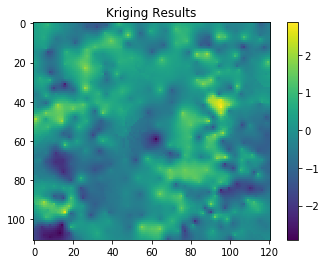

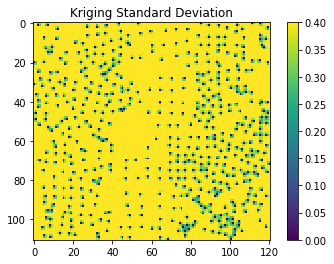

In [31]:

# plt.title('log(Kriging Results)')
# plt.imshow(np.log(interpolation_kri),
#           origin='lower')
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.show()

# plt.title('in rank space')
# plt.imshow(sst.rankdata(interpolation_kri.flatten()).reshape(Z.shape[0], Z.shape[1]),
#           origin='lower')
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.show()

plt.title('Kriging Results')
plt.imshow(interpolation_kri,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('8_Ordinary Kriging map.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.title('Kriging Standard Deviation')
plt.imshow(std_kri,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('9_Kriging Variance map.png', dpi=300) #save a nice .png of this map.
plt.show()

### Random path function

In [74]:
#Montecarlo random path

def random_path(seed, index_to_simulate): 
    #This function gives a matrix of the length of the indexes in the matrix without the observed data. it gives 
    np.random.seed(seed)
    path = np.random.choice(len(index_to_simulate),size=len(index_to_simulate), replace=False)#gives random values to change the order of the indexes according to this list
    return np.array(index_to_simulate)[path]
    
seed = 200
coord_order = random_path(seed,index_to_simulate)#Indexes random


# SGS

In [75]:
interpolation_sgs = np.copy(Z)
std_sgs = np.zeros((Z.shape[0],Z.shape[1]))
n_cond = 10
controls_sgs = controls
controlvalues_sgs = controlvalues
l =0


for n in coord_order:
#     print (n)
    targets_sgs =  np.array([[Y[0,n[1]], X[n[0],0]]]) #Select cell to calculate. It looks for the value of coordinates Y represents 
#     print(targets_sgs)
    ok_result = kri.krige_ok(controls_sgs
                       , targets_sgs
                       , controlvalues_sgs
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
#     print ('ID \t x \t y \t est(z)')    
    for i, result in enumerate(ok_result):
#         print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(l, targets_sgs[i][0], targets_sgs[i][1], result[1]))
        # the weights are stored in results[0] but not saved here
        interpolation_sgs[n[0], n[1]] = result[1]#Calculate kriging
        std_sgs[n[0], n[1]] = result[2]
        controlvalues_sgs = np.append(controlvalues_sgs,result[1])#Add cell to control values
    controls_sgs = np.append(controls_sgs, [targets_sgs], axis =0)#Add cell to control coordinates
    l = l+1


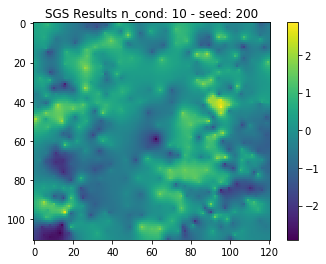

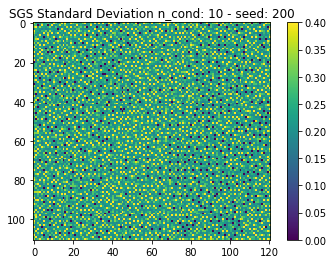

In [76]:
plt.imshow(interpolation_sgs,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.title('SGS Results n_cond: '+ str(n_cond) + ' - seed: ' + str(seed))
plt.savefig('10_SGS_map_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()


plt.title('SGS Standard Deviation n_cond: '+ str(n_cond) + ' - seed: ' + str(seed))
plt.imshow(std_sgs,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('11_SGS_std_map_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

## Back to original values units

In [77]:
#Back to original values of the data after Ordinary Kriging (without SGS)
ok_results_units_original = np.zeros((interpolation_kri.shape[0], interpolation_kri.shape[1]))
for i in range(interpolation_kri.shape[0]):
    for j in range(interpolation_kri.shape[1]):
        inter_normal = sp.interpolate.interp1d(values_cdf_normal,cdf_normal)
        cdf_value = inter_normal(interpolation_kri[i,j])
        inter = sp.interpolate.interp1d(cdf,values_cdf)
        ok_results_units_original[i,j] = inter(cdf_value)

#Back to original values of the data after SGS
sgs = np.zeros((interpolation_sgs.shape[0], interpolation_sgs.shape[1]))
for i in range(interpolation_sgs.shape[0]):
    for j in range(interpolation_sgs.shape[1]):
        inter_normal = sp.interpolate.interp1d(values_cdf_normal,cdf_normal)
        cdf_value = inter_normal(interpolation_sgs[i,j])
        inter = sp.interpolate.interp1d(cdf,values_cdf)
        sgs[i,j] = inter(cdf_value)

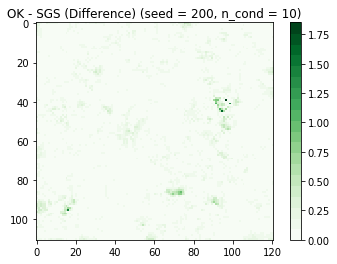

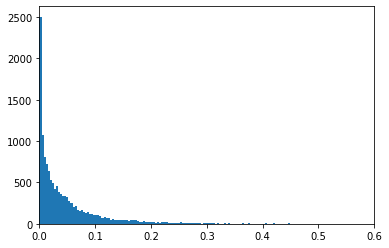

                  0
count  13431.000000
mean       0.049206
std        0.074631
min        0.000000
25%        0.006547
50%        0.025660
75%        0.062522
max        1.853078


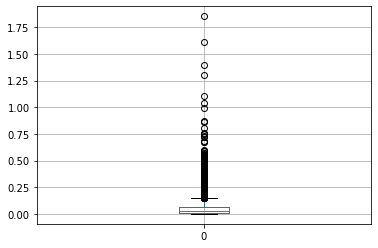

In [78]:
# plt.title('Ordinary Kriging Original units Result')
# plt.imshow(ok_results_units_original,
#           origin='lower', cmap=plt.cm.get_cmap('Greens', 20))
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.savefig('Ordinary Kriging map_original_units.png', dpi=300) #save a nice .png of this map.
# plt.show()

# plt.title('SGS Original unit Result')
# plt.imshow(sgs,
#           origin='lower', cmap=plt.cm.get_cmap('Greens', 20))
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.savefig('SGS Kriging map_original_units.png', dpi=300) #save a nice .png of this map.
# plt.show()

# Plot difference between different estimation methods.
difference_ok_sgs = abs(ok_results_units_original - sgs)
# print(difference_ok_sgs.flatten())

plt.title('OK - SGS (Difference) '+'(seed = '+str(seed)+', n_cond = '+str(n_cond)+')')
plt.imshow(difference_ok_sgs,
          origin='lower', cmap=plt.cm.get_cmap('Greens', 20))
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.savefig('12_Difference_map_original_units_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

# #statistics of difference variable
plt.hist(difference_ok_sgs.flatten(), bins=500)
plt.xlim([0 , .6])
plt.savefig('13_Difference (OK-SGS) Histogram_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()
df = pd.DataFrame(difference_ok_sgs.flatten())
print(df.describe())
df.boxplot()

## Unconditional

In [37]:
#Montecarlo random path
 
# coord_order_un = random_path(seed,index)   #Indexes random over "index" vector which contains all coordenates of grid.

In [38]:
# interpolation_sgs_un = np.copy(Z)
# std_sgs_un = np.zeros((Z.shape[0],Z.shape[1]))
# n_cond = 10
# controls_sgs_un = controls
# controlvalues_sgs_un = controlvalues
# l =0

# for n in coord_order_un:
# #     print (n)
#     targets_sgs_un =  np.array([[Y[0,n[1]], X[n[0],0]]]) #Select cell to calculate. It looks for the value of coordinates Y represents 
# #     print(targets_sgs)
# #     #Delete control value in case is part of
# #     if targets_sgs_un ESTA EN LISTA DE CONTROLS
# #         #get index
# #         index = np.where(controls_sgs_un==)
# #         controls_sgs_un = np.delete(controls_sgs_un,)
#     ok_result = kri.krige_ok(controls_sgs_un
#                        , targets_sgs_un
#                        , controlvalues_sgs_un
#                        , fitted_variogram
#                        , n_cond
#                        , verbose = True)
# #     print ('ID \t x \t y \t est(z)')    
#     for i, result in enumerate(ok_result):
# #         print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(l, targets_sgs[i][0], targets_sgs[i][1], result[1]))
#         # the weights are stored in results[0] but not saved here
#         interpolation_sgs_un[n[0], n[1]] = result[1]#Calculate kriging
#         std_sgs_un[n[0], n[1]] = result[2]
#         controlvalues_sgs_un = np.append(controlvalues_sgs_un,result[1])#Add cell to control values
#     controls_sgs_un = np.append(controls_sgs_un, [targets_sgs_un], axis =0)#Add cell to control coordinates
#     l = l+1


In [39]:
# aus = np.array([1,2,3,4,5])
# where = np.where(aus==5)
# print(where)